In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets
!pip install nltk
!pip install gensim
!pip install transformers
!pip install transformer-lens
!pip install circuitsvis
!pip install lexicalrichness


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00

In [3]:
IN_COLAB = True

import plotly.io as pio
if IN_COLAB:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [4]:
import os

# Change directory to your working directory
DATA_DIR = "/content/drive/MyDrive/NLP_Final_project/"

os.chdir(DATA_DIR)
os.getcwd()

'/content/drive/MyDrive/NLP_Final_project'

In [5]:
# some stupid hugging face bs
os.environ["WANDB_DISABLED"] = "true"


In [6]:
import torch
from torch.nn import functional as F
from torch.utils.data import Dataset
import sentencepiece as spm
import math
import multiprocessing
from datasets import load_dataset
from datasets import concatenate_datasets
from datasets import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import circuitsvis as cv
import seaborn as sns
from transformer_lens import HookedTransformer
import pickle

Loading the datasets

In [7]:
babylm = load_dataset("nilq/babylm-10M", split="train[:15%]")  # Load only 10% of data
# cnn_dailymail = load_dataset("abisee/cnn_dailymail", "3.0.0", split="train[:10%]")
# cnn_dailymail = cnn_dailymail.rename_column("article", "text")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



README.md:   0%|          | 0.00/883 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/36.2M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/37.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1058740 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1026747 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1054646 [00:00<?, ? examples/s]

### EXPLORATORY DATA ANALYSIS

In [8]:
wiki_dataset = load_dataset("wikimedia/wikipedia", data_files="20231101.en/train-00001-of-00041.parquet")

README.md:   0%|          | 0.00/131k [00:00<?, ?B/s]

train-00001-of-00041.parquet:   0%|          | 0.00/351M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

BABY Dataset Stats:
count    158811.000000
mean          7.724629
std          12.807199
min           0.000000
25%           3.000000
50%           5.000000
75%           8.000000
max        1913.000000
Name: word_count, dtype: float64 

Wiki Dataset Stats:
count    156289.000000
mean        594.571685
std         964.078815
min           1.000000
25%         149.000000
50%         332.000000
75%         682.000000
max       48059.000000
Name: word_count, dtype: float64 



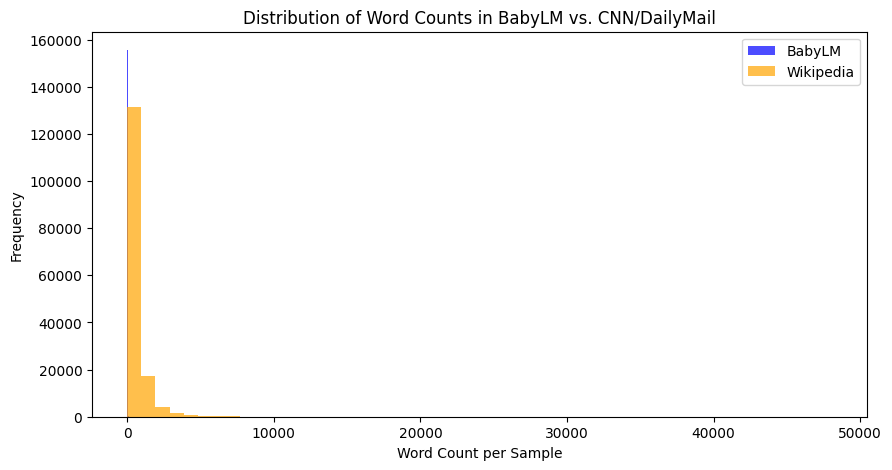

1226756
92925014


In [9]:

babylm_df = pd.DataFrame(babylm)
wikipedia_df = pd.DataFrame(wiki_dataset['train'])

# Compute word counts
babylm_df["word_count"] = babylm_df["text"].apply(lambda x: len(x.split()))
wikipedia_df["word_count"] = wikipedia_df["text"].apply(lambda x: len(x.split()))

# Print dataset word count stats
print("BABY Dataset Stats:")
print(babylm_df["word_count"].describe(), "\n")

print("Wiki Dataset Stats:")
print(wikipedia_df["word_count"].describe(), "\n")

# Plot histograms of sentence lengths
plt.figure(figsize=(10, 5))
plt.hist(babylm_df["word_count"], bins=50, alpha=0.7, label="BabyLM", color='blue')
plt.hist(wikipedia_df["word_count"], bins=50, alpha=0.7, label="Wikipedia", color='orange')
plt.legend()
plt.xlabel("Word Count per Sample")
plt.ylabel("Frequency")
plt.title("Distribution of Word Counts in BabyLM vs. CNN/DailyMail")
plt.show()

#total
total_baby_words = babylm_df["word_count"].sum()
total_adult_words = wikipedia_df["word_count"].sum()

print(total_baby_words)
print(total_adult_words)


In [10]:

wikipedia_df["cumulative_word_count"] = wikipedia_df["word_count"].cumsum()

# Sample Wikipedia until it reaches BabyLM's total word count
wikipedia_balanced = wikipedia_df[wikipedia_df["cumulative_word_count"] <= total_baby_words]

# Drop the extra column
wikipedia_balanced = wikipedia_balanced.drop(columns=["cumulative_word_count"])

# Print new total word count
print(f" Wikipedia Total Words: {wikipedia_balanced['word_count'].sum()}")
print(f" babylm Total Words: {babylm_df['word_count'].sum()}")

 Wikipedia Total Words: 1224800
 babylm Total Words: 1226756


In [11]:
babylm_df["text"] = "[BABY] " + babylm_df["text"]
wikipedia_balanced["text"] = "[ADULT] " + wikipedia_balanced["text"]

In [12]:
babylm_dataset_edited = Dataset.from_pandas(babylm_df[["text"]])  # Keep only 'text' column
wikipedia_dataset_edited = Dataset.from_pandas(wikipedia_balanced[["text"]])  # Keep only 'text' column

In [13]:
combined_dataset = concatenate_datasets([babylm_dataset_edited, wikipedia_dataset_edited])

### load in a pretrained model - GPT2

In [14]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load GPT-2 model & tokenizer
model_name = "gpt2"  # Use "gpt2-medium" or "gpt2-large" if needed
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [15]:

#tokenize the dataset

#apparently gpt2 is causal so we can do this as a quick fix: https://github.com/huggingface/transformers/issues/2630#issuecomment-1290809338

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

"""
tokenized_dataset = combined_dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])  # Remove original text
tokenized_dataset.set_format("torch")

tokenized_dataset.save_to_disk("/content/drive/MyDrive/NLP_Final_project/tokenized_dataset_v2")
"""

'\ntokenized_dataset = combined_dataset.map(tokenize_function, batched=True)\ntokenized_dataset = tokenized_dataset.remove_columns(["text"])  # Remove original text\ntokenized_dataset.set_format("torch")\n\ntokenized_dataset.save_to_disk("/content/drive/MyDrive/NLP_Final_project/tokenized_dataset_v2")\n'

In [16]:
from datasets import load_from_disk

tokenized_dataset = load_from_disk("/content/drive/MyDrive/NLP_Final_project/tokenized_dataset_v2")
tokenized_dataset = tokenized_dataset.remove_columns(["__index_level_0__"])

In [17]:
"""
# test
small_train_dataset = tokenized_dataset.select(range(100))  # Adjust as needed
small_train_dataset
"""

'\n# test\nsmall_train_dataset = tokenized_dataset.select(range(100))  # Adjust as needed\nsmall_train_dataset\n'

### MODEL FINE TUNING

In [18]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/NLP_Final_project/gpt2_finetuned_ckpt_2",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    save_steps=2000,
    save_strategy="steps",
    logging_steps=500,
    gradient_accumulation_steps=4,
    save_total_limit=1,  # Keep only last 2 checkpoints
    load_best_model_at_end=False,  # No eval, so we can't load "best" model
    fp16=True,
)

#doing this agian hiarer
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

#big boy dataset
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)


# trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [19]:
from transformers import AutoModelForCausalLM, AutoTokenizer

checkpoint_path = "/content/drive/MyDrive/NLP_Final_project/gpt2_finetuned_ckpt_2/checkpoint-15087"
model = AutoModelForCausalLM.from_pretrained(checkpoint_path)

In [20]:
"""
#input a new prompt
prompt = "[BABY] mom"
#prompt = "[ADULT] mom"

input_ids = tokenizer.encode(prompt, return_tensors="pt")

# set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
sample_outputs = model.generate(
    input_ids,
    max_new_tokens=50,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=3,
)

print(tokenizer.decode(sample_outputs[0], skip_special_tokens=True))
"""

'\n#input a new prompt\nprompt = "[BABY] mom"\n#prompt = "[ADULT] mom"\n\ninput_ids = tokenizer.encode(prompt, return_tensors="pt")\n\n# set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3\nsample_outputs = model.generate(\n    input_ids,\n    max_new_tokens=50,\n    do_sample=True,\n    top_k=50,\n    top_p=0.95,\n    num_return_sequences=3,\n)\n\nprint(tokenizer.decode(sample_outputs[0], skip_special_tokens=True))\n'

In [21]:
with open('/content/drive/MyDrive/NLP_Final_project/baby_prompts.pkl', 'rb') as f:
    baby_prompts = pickle.load(f)

with open('/content/drive/MyDrive/NLP_Final_project/adult_prompts.pkl', 'rb') as f:
    adult_prompts = pickle.load(f)

In [22]:
tl_model = HookedTransformer.from_pretrained(model_name, hf_model=model)

Loaded pretrained model gpt2 into HookedTransformer


In [23]:
"""
text = "Dogs like to run! They are friendly."

# Tokenize input
tokens = tokenizer(text, return_tensors="pt")["input_ids"]

# Run model with cache (captures activations)
_, cache = tl_model.run_with_cache(tokens)
"""

'\ntext = "Dogs like to run! They are friendly."\n\n# Tokenize input\ntokens = tokenizer(text, return_tensors="pt")["input_ids"]\n\n# Run model with cache (captures activations)\n_, cache = tl_model.run_with_cache(tokens)\n'

CODE TO FIND "AVERAGE BABY VECTOR" AND "AVERAGE ADULT VECTOR"

In [24]:
import torch

def accumulate_activations(prompts, model, selected_layers):
    """
    Runs multiple prompts through the model and accumulates activations
    for selected layers across all tokens.

    Instead of averaging per prompt, we concatenate all activations and
    only average at the end.

    Args:
        prompts (list): Tokenized input prompts.
        model: TransformerLens model.
        selected_layers (list): List of layer names to accumulate activations from.

    Returns:
        dict: Final averaged activations for selected layers.
    """
    accumulated_cache = {key: [] for key in selected_layers}  # Stores concatenated activations

    for tokenized_prompt in prompts:  # Prompts are already tokenized
        _, cache = model.run_with_cache(tokenized_prompt.to("cuda"))
        #print(cache.keys())
        #return

        for key in selected_layers:
            if key in cache:
                accumulated_cache[key].append(cache[key])  # Collect all activations

    # Concatenate along sequence length dimension
    for key in accumulated_cache:
        accumulated_cache[key] = torch.cat(accumulated_cache[key], dim=1)  # Merge all sequences

    # Compute final averaged activations across all accumulated tokens
    averaged_cache = {key: accumulated_cache[key].mean(dim=1, keepdim=True) for key in accumulated_cache}

    return averaged_cache, accumulated_cache  # Returns dictionary of final averaged activations

baby_averages, baby_cache = accumulate_activations(baby_prompts, tl_model, ["blocks.0.hook_resid_post", "blocks.1.hook_resid_post", "blocks.2.hook_resid_post", "blocks.3.hook_resid_post", "blocks.4.hook_resid_post", "blocks.5.hook_resid_post", "blocks.6.hook_resid_post", "blocks.7.hook_resid_post", "blocks.8.hook_resid_post", "blocks.9.hook_resid_post", "blocks.10.hook_resid_post", "blocks.11.hook_resid_post"])
adult_averages, adult_cache = accumulate_activations(adult_prompts, tl_model, ["blocks.0.hook_resid_post", "blocks.1.hook_resid_post", "blocks.2.hook_resid_post", "blocks.3.hook_resid_post", "blocks.4.hook_resid_post", "blocks.5.hook_resid_post", "blocks.6.hook_resid_post", "blocks.7.hook_resid_post", "blocks.8.hook_resid_post", "blocks.9.hook_resid_post", "blocks.10.hook_resid_post", "blocks.11.hook_resid_post"])

In [25]:
adult_minus_baby = {}
for k in adult_averages.keys():
  adult_minus_baby[k] = adult_averages[k] - baby_averages[k]

baby_minus_adult = dict()
for k in adult_minus_baby.keys():
  baby_minus_adult[k] = -1 * adult_minus_baby[k]

In [26]:
def generate_with_patching(prompt, patched_values_dict, layers_to_patch, no_patch = False, num_generation = 20, section="hook_resid_post"):
    """
    Generates text while applying activation patching at each forward pass.

    Args:
    - prompt: The input prompt string.
    - patched_values_dict: A dictionary mapping layers, to patches that should be applied for that layer. (PATCH SHOULD BE OF SHAPE: torch.Size([1, 1, hidden_size]))
    - layers_to_patch: List of integers. Specifies which layers to patch (0-11)
    - no_patch: If True, patches with 0s (same as unpatched)

    Returns:
    - The generated text.
    """
    # Tokenize input
    #input_ids = torch.tensor(prompt)
    input_ids = torch.tensor([tokenizer.encode(prompt)])

    patch_position = len(input_ids[0]-1)

    # Move to model's device
    input_ids = input_ids.to("cuda")

    # Store generated tokens
    generated_tokens = input_ids.clone()
    #print(generated_tokens)

    # vector of zeros, used in patching
    zeros = torch.zeros_like(tl_model.run_with_cache("")[-1][f"blocks.{0}.{section}"])  # Example patch

    def create_hook(layer):
        """
        Creates a hook function for a specific layer.
        """
        patched_values = patched_values_dict[f"blocks.{layer}.{section}"]

        def temporary_hook(activation, hook):
            if no_patch:
              return activation

            if generated_tokens.shape[1] - 1 >= patch_position:
                zero_size = patch_position
                zero_tensor = zeros.repeat(1, zero_size, 1)

                patch_size = max(0, generated_tokens.shape[1] - patch_position)
                patch_tensor = patched_values.repeat(1, patch_size, 1)

                patched_activations = torch.cat((zero_tensor, patch_tensor), dim=1)
                return activation + patched_activations

            return activation

        return temporary_hook


    for _ in range(num_generation):  # Generate up to 20 tokens
        # Run model forward pass with activation patching
        #tl_model.reset_hooks()

        hooks = [(f"blocks.{layer}.{section}", create_hook(layer)) for layer in layers_to_patch]

        #with tl_model.hooks(fwd_hooks=[(f"blocks.{0}.hook_resid_post", temporary_hook), (f"blocks.{1}.hook_resid_post", temporary_hook)]):
        with tl_model.hooks(fwd_hooks=hooks):
          logits = tl_model(generated_tokens)

        # Sample next token
        next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)

        # Append to sequence
        generated_tokens = torch.cat([generated_tokens, next_token], dim=-1)

        # Stop if EOS token is generated
        if next_token.item() == tokenizer.eos_token_id:
            break
    tl_model.reset_hooks() # Clear hooks since they are global
    return generated_tokens[0]

In [27]:
unpatched_text = generate_with_patching("[BABY] Th", patched_values_dict=adult_minus_baby, layers_to_patch=[0], no_patch = True)
tokenizer.decode(unpatched_text)

'[BABY] Thirteen years ago, when I was a child, I was a child of a family of four,'

In [28]:
patched_text = generate_with_patching("[BABY] Th", patched_values_dict=adult_minus_baby, layers_to_patch=[11], no_patch=False)
tokenizer.decode(patched_text)

'[BABY] Thirteen years ago, the United Kingdom was a member of the European Union. Now, it is a'

In [29]:
from lexicalrichness import LexicalRichness

In [30]:
prompts = [tokenizer.decode(baby_prompts[i][0])[:30] for i in np.random.choice(1000, 40)]
#prompts = ["[BABY] You are so", "[BABY] Hello my name", "[BABY] Today, the", "[BABY] I want to", "[BABY] I want my", "[BABY] Dogs like to", "[BABY] I really don't like", "[BABY] Mom", "[BABY] Some things are just", "[BABY] These are"]
"""
unpatched_results = [[] for _ in range(12)]
patched_results = [[] for _ in range(12)]

for layer in range(12):
  for prompt in prompts:
    unpatched_result = generate_with_patching(prompt, patched_values_dict=adult_minus_baby, layers_to_patch=[layer], no_patch = True, num_generation=50)
    patched_result = generate_with_patching(prompt, patched_values_dict=adult_minus_baby, layers_to_patch=[layer], no_patch=False, num_generation=50)

    unpatched_results[layer].append(tokenizer.decode(unpatched_result)[7:])
    patched_results[layer].append(tokenizer.decode(patched_result)[7:])

with open("/content/drive/MyDrive/NLP_Final_project/unpatched_results.pkl", "wb") as file:
    pickle.dump(unpatched_results, file)

with open("/content/drive/MyDrive/NLP_Final_project/patched_results.pkl", "wb") as file:
    pickle.dump(patched_results, file)
"""

'\nunpatched_results = [[] for _ in range(12)]\npatched_results = [[] for _ in range(12)]\n\nfor layer in range(12):\n  for prompt in prompts:\n    unpatched_result = generate_with_patching(prompt, patched_values_dict=adult_minus_baby, layers_to_patch=[layer], no_patch = True, num_generation=50)\n    patched_result = generate_with_patching(prompt, patched_values_dict=adult_minus_baby, layers_to_patch=[layer], no_patch=False, num_generation=50)\n\n    unpatched_results[layer].append(tokenizer.decode(unpatched_result)[7:])\n    patched_results[layer].append(tokenizer.decode(patched_result)[7:])\n\nwith open("/content/drive/MyDrive/NLP_Final_project/unpatched_results.pkl", "wb") as file:\n    pickle.dump(unpatched_results, file)\n\nwith open("/content/drive/MyDrive/NLP_Final_project/patched_results.pkl", "wb") as file:\n    pickle.dump(patched_results, file)\n'

In [31]:
with open('/content/drive/MyDrive/NLP_Final_project/unpatched_results.pkl', 'rb') as f:
    unpatched_results = pickle.load(f)

with open('/content/drive/MyDrive/NLP_Final_project/patched_results.pkl', 'rb') as f:
    patched_results = pickle.load(f)

In [32]:
unpatched_richness = [[[] for _ in range(len(prompts))] for _ in range(12)] # For each of 12 layers, gives TTR, MATTR, MTLD
patched_richness  =  [[[] for _ in range(len(prompts))] for _ in range(12)] # For each of 12 layers, gives TTR, MATTR, MTLD

for layer in range(len(patched_results)):
  for prompt in range(len(patched_results[0])):
    lex_unpatched = LexicalRichness(unpatched_results[layer][prompt])
    lex_patched  =  LexicalRichness(patched_results[layer][prompt])

    unpatched_richness[layer][prompt].append(lex_unpatched.ttr)
    #unpatched_richness[layer][prompt].append(lex_unpatched.mattr(window_size=5))
    unpatched_richness[layer][prompt].append(lex_unpatched.mtld())

    patched_richness[layer][prompt].append(lex_patched.ttr)
    #patched_richness[layer][prompt].append(lex_patched.mattr(window_size=5))
    patched_richness[layer][prompt].append(lex_patched.mtld())

unpatched_richness = torch.tensor(unpatched_richness)
patched_richness = torch.tensor(patched_richness)

In [33]:
# TTR and MTLD by patched layer (patches inactive (baseline)) and all prompts (10)
unpatched_richness.mean(dim=1)

tensor([[ 0.2907, 10.6866],
        [ 0.2907, 10.6866],
        [ 0.2907, 10.6866],
        [ 0.2907, 10.6866],
        [ 0.2907, 10.6866],
        [ 0.2907, 10.6866],
        [ 0.2907, 10.6866],
        [ 0.2907, 10.6866],
        [ 0.2907, 10.6866],
        [ 0.2907, 10.6866],
        [ 0.2907, 10.6866],
        [ 0.2907, 10.6866]])

In [34]:
# TTR and MTLD by patched layer (patches active) and all prompts (10)
patched_richness.mean(dim=1)

tensor([[ 0.3039, 11.4099],
        [ 0.3006, 11.3766],
        [ 0.2766, 11.2115],
        [ 0.2865, 11.4406],
        [ 0.2882,  9.7863],
        [ 0.3121, 11.6086],
        [ 0.3101, 11.8045],
        [ 0.3157, 11.5300],
        [ 0.2928, 11.3082],
        [ 0.3049, 11.5821],
        [ 0.3334, 13.7128],
        [ 0.3141, 11.7736]])

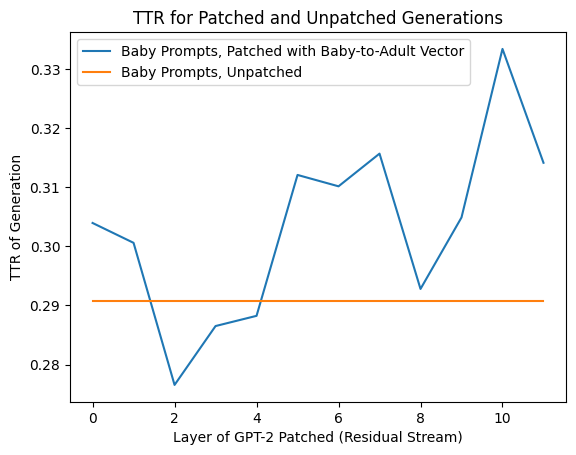

In [35]:
plt.plot(patched_richness.mean(dim=1)[:,0], label="Baby Prompts, Patched with Baby-to-Adult Vector")
plt.plot(unpatched_richness.mean(dim=1)[:,0], label = "Baby Prompts, Unpatched")
plt.title("TTR for Patched and Unpatched Generations")
plt.xlabel("Layer of GPT-2 Patched (Residual Stream)")
plt.ylabel("TTR of Generation")
plt.legend()
plt.show()

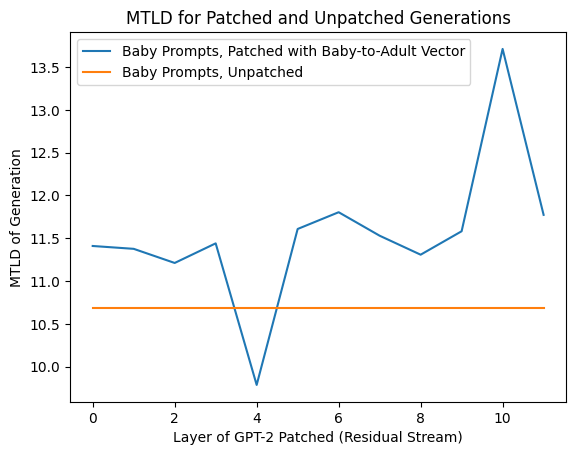

In [36]:
plt.plot(patched_richness.mean(dim=1)[:,1], label="Baby Prompts, Patched with Baby-to-Adult Vector")
plt.plot(unpatched_richness.mean(dim=1)[:,1], label = "Baby Prompts, Unpatched")
plt.title("MTLD for Patched and Unpatched Generations")
plt.xlabel("Layer of GPT-2 Patched (Residual Stream)")
plt.ylabel("MTLD of Generation")
plt.legend()
plt.show()

In [37]:
# TTR and MTLD, averaged over all layers (patches inactive (baseline)) and all prompts (10)
unpatched_richness.mean(dim=1).mean(dim=0)

tensor([ 0.2907, 10.6866])

In [38]:
# TTR and MTLD, averaged over all layers (patches active)  and all prompts (10)
patched_richness.mean(dim=1).mean(dim=0)

tensor([ 0.3032, 11.5454])

In [39]:
#prompts_adult_to_baby = ["[ADULT] You are so", "[ADULT] Hello my name", "[ADULT] Today, the", "[ADULT] I want to", "[ADULT] I want my", "[ADULT] Dogs like to", "[ADULT] I really don't like", "[ADULT] Mom", "[ADULT] Some things are just", "[ADULT] These are"]
prompts_adult_to_baby = [tokenizer.decode(adult_prompts[i][0])[:30] for i in np.random.choice(1000, 40)]

"""
unpatched_results_adult_to_baby = [[] for _ in range(12)]
patched_results_adult_to_baby = [[] for _ in range(12)]

for layer in range(12):
  for prompt in prompts_adult_to_baby:
    unpatched_result = generate_with_patching(prompt, patched_values_dict=baby_minus_adult, layers_to_patch=[layer], no_patch = True, num_generation=50)
    patched_result = generate_with_patching(prompt, patched_values_dict=baby_minus_adult, layers_to_patch=[layer], no_patch=False, num_generation=50)

    unpatched_results_adult_to_baby[layer].append(tokenizer.decode(unpatched_result)[7:])
    patched_results_adult_to_baby[layer].append(tokenizer.decode(patched_result)[7:])

with open("/content/drive/MyDrive/NLP_Final_project/unpatched_results_adult_to_baby.pkl", "wb") as file:
    pickle.dump(unpatched_results_adult_to_baby, file)

with open("/content/drive/MyDrive/NLP_Final_project/patched_results_adult_to_baby.pkl", "wb") as file:
    pickle.dump(patched_results_adult_to_baby, file)
"""

'\nunpatched_results_adult_to_baby = [[] for _ in range(12)]\npatched_results_adult_to_baby = [[] for _ in range(12)]\n\nfor layer in range(12):\n  for prompt in prompts_adult_to_baby:\n    unpatched_result = generate_with_patching(prompt, patched_values_dict=baby_minus_adult, layers_to_patch=[layer], no_patch = True, num_generation=50)\n    patched_result = generate_with_patching(prompt, patched_values_dict=baby_minus_adult, layers_to_patch=[layer], no_patch=False, num_generation=50)\n\n    unpatched_results_adult_to_baby[layer].append(tokenizer.decode(unpatched_result)[7:])\n    patched_results_adult_to_baby[layer].append(tokenizer.decode(patched_result)[7:])\n\nwith open("/content/drive/MyDrive/NLP_Final_project/unpatched_results_adult_to_baby.pkl", "wb") as file:\n    pickle.dump(unpatched_results_adult_to_baby, file)\n\nwith open("/content/drive/MyDrive/NLP_Final_project/patched_results_adult_to_baby.pkl", "wb") as file:\n    pickle.dump(patched_results_adult_to_baby, file)\n'

In [40]:
with open('/content/drive/MyDrive/NLP_Final_project/unpatched_results_adult_to_baby.pkl', 'rb') as f:
    unpatched_results_adult_to_baby = pickle.load(f)

with open('/content/drive/MyDrive/NLP_Final_project/patched_results_adult_to_baby.pkl', 'rb') as f:
    patched_results_adult_to_baby = pickle.load(f)

In [41]:
unpatched_richness_adult_to_baby = [[[] for _ in range(len(prompts))] for _ in range(12)] # For each of 12 layers, gives TTR, MATTR, MTLD
patched_richness_adult_to_baby  =  [[[] for _ in range(len(prompts))] for _ in range(12)] # For each of 12 layers, gives TTR, MATTR, MTLD

for layer in range(len(patched_results_adult_to_baby)):
  for prompt in range(len(patched_results_adult_to_baby[0])):
    lex_unpatched = LexicalRichness(unpatched_results_adult_to_baby[layer][prompt])
    lex_patched  =  LexicalRichness(patched_results_adult_to_baby[layer][prompt])

    unpatched_richness_adult_to_baby[layer][prompt].append(lex_unpatched.ttr)
    #unpatched_richness[layer][prompt].append(lex_unpatched.mattr(window_size=5))
    unpatched_richness_adult_to_baby[layer][prompt].append(lex_unpatched.mtld())

    patched_richness_adult_to_baby[layer][prompt].append(lex_patched.ttr)
    #patched_richness[layer][prompt].append(lex_patched.mattr(window_size=5))
    patched_richness_adult_to_baby[layer][prompt].append(lex_patched.mtld())

unpatched_richness_adult_to_baby = torch.tensor(unpatched_richness_adult_to_baby)
patched_richness_adult_to_baby = torch.tensor(patched_richness_adult_to_baby)

In [42]:
# TTR and MTLD by patched layer (patches inactive (baseline)) and all prompts (10)
unpatched_richness_adult_to_baby.mean(dim=1)

tensor([[ 0.3851, 14.8550],
        [ 0.3851, 14.8550],
        [ 0.3851, 14.8550],
        [ 0.3851, 14.8550],
        [ 0.3851, 14.8550],
        [ 0.3851, 14.8550],
        [ 0.3851, 14.8550],
        [ 0.3851, 14.8550],
        [ 0.3851, 14.8550],
        [ 0.3851, 14.8550],
        [ 0.3851, 14.8550],
        [ 0.3851, 14.8550]])

In [43]:
# TTR and MTLD by patched layer (patches active) and all prompts (10)
patched_richness_adult_to_baby.mean(dim=1)

tensor([[ 0.3849, 15.4358],
        [ 0.4000, 14.2381],
        [ 0.3926, 16.2939],
        [ 0.3736, 13.7233],
        [ 0.3610, 14.2379],
        [ 0.3370, 12.3633],
        [ 0.3408, 13.7735],
        [ 0.4069, 16.8544],
        [ 0.3874, 13.7172],
        [ 0.4033, 13.7560],
        [ 0.3806, 11.5472],
        [ 0.3955, 11.9291]])

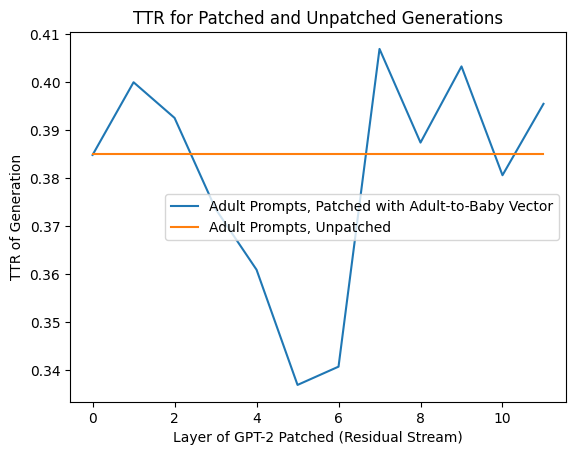

In [44]:
plt.plot(patched_richness_adult_to_baby.mean(dim=1)[:,0], label="Adult Prompts, Patched with Adult-to-Baby Vector")
plt.plot(unpatched_richness_adult_to_baby.mean(dim=1)[:,0], label = "Adult Prompts, Unpatched")
plt.title("TTR for Patched and Unpatched Generations")
plt.xlabel("Layer of GPT-2 Patched (Residual Stream)")
plt.ylabel("TTR of Generation")
plt.legend()
plt.show()

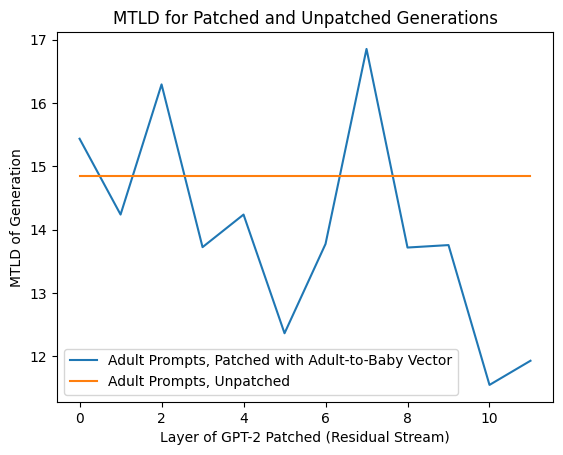

In [45]:
plt.plot(patched_richness_adult_to_baby.mean(dim=1)[:,1], label="Adult Prompts, Patched with Adult-to-Baby Vector")
plt.plot(unpatched_richness_adult_to_baby.mean(dim=1)[:,1], label = "Adult Prompts, Unpatched")
plt.title("MTLD for Patched and Unpatched Generations")
plt.xlabel("Layer of GPT-2 Patched (Residual Stream)")
plt.ylabel("MTLD of Generation")
plt.legend()
plt.show()

In [46]:
# TTR and MTLD, averaged over all layers (patches inactive (baseline)) and all prompts (10)
unpatched_richness_adult_to_baby.mean(dim=1).mean(dim=0)

tensor([ 0.3851, 14.8550])

In [47]:
# TTR and MTLD, averaged over all layers (patches active)  and all prompts (10)
patched_richness_adult_to_baby.mean(dim=1).mean(dim=0)

tensor([ 0.3803, 13.9891])

END OF RESIDUAL FLOW TESTING

In [48]:
baby_averages, baby_cache = accumulate_activations(baby_prompts, tl_model, ['blocks.0.hook_attn_out', 'blocks.1.hook_attn_out', 'blocks.2.hook_attn_out', 'blocks.3.hook_attn_out', 'blocks.4.hook_attn_out', 'blocks.5.hook_attn_out', 'blocks.6.hook_attn_out', 'blocks.7.hook_attn_out', 'blocks.8.hook_attn_out', 'blocks.9.hook_attn_out', 'blocks.10.hook_attn_out', 'blocks.11.hook_attn_out'])
adult_averages, adult_cache = accumulate_activations(adult_prompts, tl_model, ['blocks.0.hook_attn_out', 'blocks.1.hook_attn_out', 'blocks.2.hook_attn_out', 'blocks.3.hook_attn_out', 'blocks.4.hook_attn_out', 'blocks.5.hook_attn_out', 'blocks.6.hook_attn_out', 'blocks.7.hook_attn_out', 'blocks.8.hook_attn_out', 'blocks.9.hook_attn_out', 'blocks.10.hook_attn_out', 'blocks.11.hook_attn_out'])

In [49]:
adult_minus_baby = {}
for k in adult_averages.keys():
  adult_minus_baby[k] = adult_averages[k] - baby_averages[k]

baby_minus_adult = dict()
for k in adult_minus_baby.keys():
  baby_minus_adult[k] = -1 * adult_minus_baby[k]

In [50]:
prompts = [tokenizer.decode(baby_prompts[i][0])[:30] for i in np.random.choice(1000, 40)]

"""
unpatched_results_attn = [[] for _ in range(12)]
patched_results_attn = [[] for _ in range(12)]

for layer in range(12):
  for prompt in prompts:
    unpatched_result_attn = generate_with_patching(prompt, patched_values_dict=adult_minus_baby, layers_to_patch=[layer], no_patch = True, num_generation=50, section="hook_attn_out")
    patched_result_attn = generate_with_patching(prompt, patched_values_dict=adult_minus_baby, layers_to_patch=[layer], no_patch=False, num_generation=50, section="hook_attn_out")

    unpatched_results_attn[layer].append(tokenizer.decode(unpatched_result_attn)[7:])
    patched_results_attn[layer].append(tokenizer.decode(patched_result_attn)[7:])

with open("/content/drive/MyDrive/NLP_Final_project/unpatched_results_attn.pkl", "wb") as file:
    pickle.dump(unpatched_results_attn, file)

with open("/content/drive/MyDrive/NLP_Final_project/patched_results_attn.pkl", "wb") as file:
    pickle.dump(patched_results_attn, file)
"""

'\nunpatched_results_attn = [[] for _ in range(12)]\npatched_results_attn = [[] for _ in range(12)]\n\nfor layer in range(12):\n  for prompt in prompts:\n    unpatched_result_attn = generate_with_patching(prompt, patched_values_dict=adult_minus_baby, layers_to_patch=[layer], no_patch = True, num_generation=50, section="hook_attn_out")\n    patched_result_attn = generate_with_patching(prompt, patched_values_dict=adult_minus_baby, layers_to_patch=[layer], no_patch=False, num_generation=50, section="hook_attn_out")\n\n    unpatched_results_attn[layer].append(tokenizer.decode(unpatched_result_attn)[7:])\n    patched_results_attn[layer].append(tokenizer.decode(patched_result_attn)[7:])\n\nwith open("/content/drive/MyDrive/NLP_Final_project/unpatched_results_attn.pkl", "wb") as file:\n    pickle.dump(unpatched_results_attn, file)\n\nwith open("/content/drive/MyDrive/NLP_Final_project/patched_results_attn.pkl", "wb") as file:\n    pickle.dump(patched_results_attn, file)\n'

In [51]:
with open('/content/drive/MyDrive/NLP_Final_project/unpatched_results_attn.pkl', 'rb') as f:
    unpatched_results_attn = pickle.load(f)

with open('/content/drive/MyDrive/NLP_Final_project/patched_results_attn.pkl', 'rb') as f:
    patched_results_attn = pickle.load(f)

In [52]:
unpatched_richness_attn = [[[] for _ in range(len(prompts))] for _ in range(12)] # For each of 12 layers, gives TTR, MATTR, MTLD
patched_richness_attn  =  [[[] for _ in range(len(prompts))] for _ in range(12)] # For each of 12 layers, gives TTR, MATTR, MTLD

for layer in range(len(patched_results_attn)):
  for prompt in range(len(patched_results_attn[0])):
    lex_unpatched = LexicalRichness(unpatched_results_attn[layer][prompt])
    lex_patched  =  LexicalRichness(patched_results_attn[layer][prompt])

    unpatched_richness_attn[layer][prompt].append(lex_unpatched.ttr)
    #unpatched_richness_attn[layer][prompt].append(lex_unpatched.mattr(window_size=5))
    unpatched_richness_attn[layer][prompt].append(lex_unpatched.mtld())

    patched_richness_attn[layer][prompt].append(lex_patched.ttr)
    #patched_richness_attn[layer][prompt].append(lex_patched.mattr(window_size=5))
    patched_richness_attn[layer][prompt].append(lex_patched.mtld())

unpatched_richness_attn = torch.tensor(unpatched_richness_attn)
patched_richness_attn = torch.tensor(patched_richness_attn)

In [53]:
# TTR and MTLD by patched layer (patches inactive (baseline)) and all prompts (10)
unpatched_richness_attn.mean(dim=1)

tensor([[ 0.3125, 11.4140],
        [ 0.3125, 11.4140],
        [ 0.3125, 11.4140],
        [ 0.3125, 11.4140],
        [ 0.3125, 11.4140],
        [ 0.3125, 11.4140],
        [ 0.3125, 11.4140],
        [ 0.3125, 11.4140],
        [ 0.3125, 11.4140],
        [ 0.3125, 11.4140],
        [ 0.3125, 11.4140],
        [ 0.3125, 11.4140]])

In [54]:
# TTR and MTLD by patched layer (patches active) and all prompts (10)
patched_richness_attn.mean(dim=1)

tensor([[ 0.3117, 11.8888],
        [ 0.3379, 12.5244],
        [ 0.3114, 11.4846],
        [ 0.3479, 11.8850],
        [ 0.3347, 13.3861],
        [ 0.3071, 12.5175],
        [ 0.3044, 11.9072],
        [ 0.3163, 11.1162],
        [ 0.3262, 13.5206],
        [ 0.3152, 13.1585],
        [ 0.3312, 11.6986],
        [ 0.3088, 12.6770]])

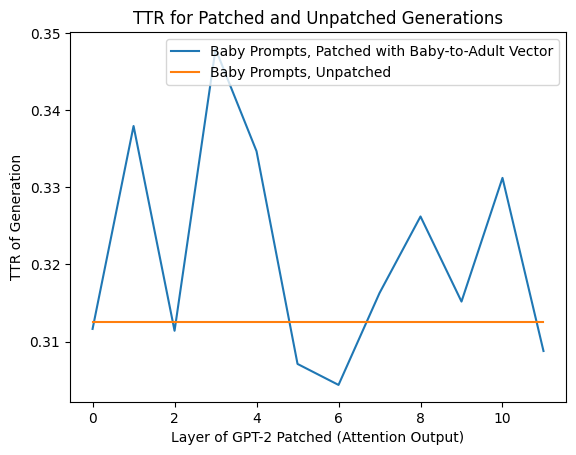

In [55]:
plt.plot(patched_richness_attn.mean(dim=1)[:,0], label="Baby Prompts, Patched with Baby-to-Adult Vector")
plt.plot(unpatched_richness_attn.mean(dim=1)[:,0], label = "Baby Prompts, Unpatched")
plt.title("TTR for Patched and Unpatched Generations")
plt.xlabel("Layer of GPT-2 Patched (Attention Output)")
plt.ylabel("TTR of Generation")
plt.legend()
plt.show()

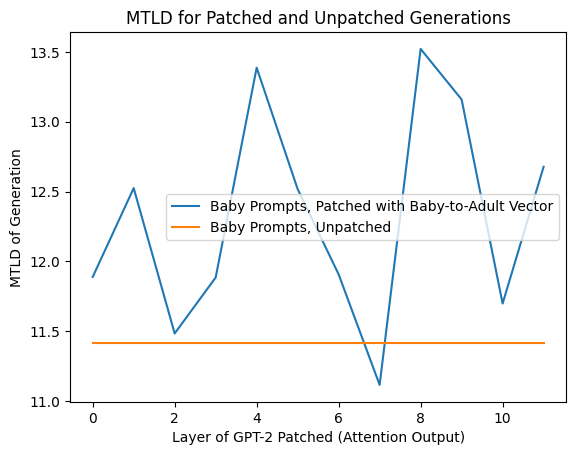

In [56]:
plt.plot(patched_richness_attn.mean(dim=1)[:,1], label="Baby Prompts, Patched with Baby-to-Adult Vector")
plt.plot(unpatched_richness_attn.mean(dim=1)[:,1], label = "Baby Prompts, Unpatched")
plt.title("MTLD for Patched and Unpatched Generations")
plt.xlabel("Layer of GPT-2 Patched (Attention Output)")
plt.ylabel("MTLD of Generation")
plt.legend()
plt.show()

In [57]:
prompts_adult_to_baby = [tokenizer.decode(adult_prompts[i][0])[:30] for i in np.random.choice(1000, 40)]

"""
unpatched_results_adult_to_baby_attn = [[] for _ in range(12)]
patched_results_adult_to_baby_attn = [[] for _ in range(12)]

for layer in range(12):
  for prompt in prompts_adult_to_baby:
    unpatched_result = generate_with_patching(prompt, patched_values_dict=baby_minus_adult, layers_to_patch=[layer], no_patch = True, num_generation=50, section="hook_attn_out")
    patched_result = generate_with_patching(prompt, patched_values_dict=baby_minus_adult, layers_to_patch=[layer], no_patch=False, num_generation=50, section="hook_attn_out")

    unpatched_results_adult_to_baby_attn[layer].append(tokenizer.decode(unpatched_result)[7:])
    patched_results_adult_to_baby_attn[layer].append(tokenizer.decode(patched_result)[7:])

with open("/content/drive/MyDrive/NLP_Final_project/unpatched_results_adult_to_baby_attn.pkl", "wb") as file:
    pickle.dump(unpatched_results_adult_to_baby_attn, file)

with open("/content/drive/MyDrive/NLP_Final_project/patched_results_adult_to_baby_attn.pkl", "wb") as file:
    pickle.dump(patched_results_adult_to_baby_attn, file)
"""

'\nunpatched_results_adult_to_baby_attn = [[] for _ in range(12)]\npatched_results_adult_to_baby_attn = [[] for _ in range(12)]\n\nfor layer in range(12):\n  for prompt in prompts_adult_to_baby:\n    unpatched_result = generate_with_patching(prompt, patched_values_dict=baby_minus_adult, layers_to_patch=[layer], no_patch = True, num_generation=50, section="hook_attn_out")\n    patched_result = generate_with_patching(prompt, patched_values_dict=baby_minus_adult, layers_to_patch=[layer], no_patch=False, num_generation=50, section="hook_attn_out")\n\n    unpatched_results_adult_to_baby_attn[layer].append(tokenizer.decode(unpatched_result)[7:])\n    patched_results_adult_to_baby_attn[layer].append(tokenizer.decode(patched_result)[7:])\n\nwith open("/content/drive/MyDrive/NLP_Final_project/unpatched_results_adult_to_baby_attn.pkl", "wb") as file:\n    pickle.dump(unpatched_results_adult_to_baby_attn, file)\n\nwith open("/content/drive/MyDrive/NLP_Final_project/patched_results_adult_to_baby_a

In [58]:
with open('/content/drive/MyDrive/NLP_Final_project/unpatched_results_adult_to_baby_attn.pkl', 'rb') as f:
    unpatched_results_adult_to_baby_attn = pickle.load(f)

with open('/content/drive/MyDrive/NLP_Final_project/patched_results_adult_to_baby_attn.pkl', 'rb') as f:
    patched_results_adult_to_baby_attn = pickle.load(f)

In [59]:
unpatched_richness_adult_to_baby_attn = [[[] for _ in range(len(prompts))] for _ in range(12)] # For each of 12 layers, gives TTR, MATTR, MTLD
patched_richness_adult_to_baby_attn  =  [[[] for _ in range(len(prompts))] for _ in range(12)] # For each of 12 layers, gives TTR, MATTR, MTLD

for layer in range(len(patched_results_adult_to_baby_attn)):
  for prompt in range(len(patched_results_adult_to_baby_attn[0])):
    lex_unpatched = LexicalRichness(unpatched_results_adult_to_baby_attn[layer][prompt])
    lex_patched  =  LexicalRichness(patched_results_adult_to_baby_attn[layer][prompt])

    unpatched_richness_adult_to_baby_attn[layer][prompt].append(lex_unpatched.ttr)
    #unpatched_richness[layer][prompt].append(lex_unpatched.mattr(window_size=5))
    unpatched_richness_adult_to_baby_attn[layer][prompt].append(lex_unpatched.mtld())

    patched_richness_adult_to_baby_attn[layer][prompt].append(lex_patched.ttr)
    #patched_richness[layer][prompt].append(lex_patched.mattr(window_size=5))
    patched_richness_adult_to_baby_attn[layer][prompt].append(lex_patched.mtld())

unpatched_richness_adult_to_baby_attn = torch.tensor(unpatched_richness_adult_to_baby_attn)
patched_richness_adult_to_baby_attn = torch.tensor(patched_richness_adult_to_baby_attn)

In [60]:
# TTR and MTLD by patched layer (patches inactive (baseline)) and all prompts (10)
unpatched_richness_adult_to_baby_attn.mean(dim=1)

tensor([[ 0.4811, 17.5728],
        [ 0.4811, 17.5728],
        [ 0.4811, 17.5728],
        [ 0.4811, 17.5728],
        [ 0.4811, 17.5728],
        [ 0.4811, 17.5728],
        [ 0.4811, 17.5728],
        [ 0.4811, 17.5728],
        [ 0.4811, 17.5728],
        [ 0.4811, 17.5728],
        [ 0.4811, 17.5728],
        [ 0.4811, 17.5728]])

In [61]:
# TTR and MTLD by patched layer (patches active) and all prompts (10)
patched_richness_adult_to_baby_attn.mean(dim=1)

tensor([[ 0.4795, 16.1952],
        [ 0.4589, 15.8409],
        [ 0.4303, 15.2643],
        [ 0.4662, 16.1960],
        [ 0.4302, 15.2831],
        [ 0.4651, 16.8884],
        [ 0.4233, 18.7312],
        [ 0.4600, 19.2714],
        [ 0.4539, 16.9073],
        [ 0.4659, 18.1911],
        [ 0.4451, 14.9747],
        [ 0.4505, 14.4340]])

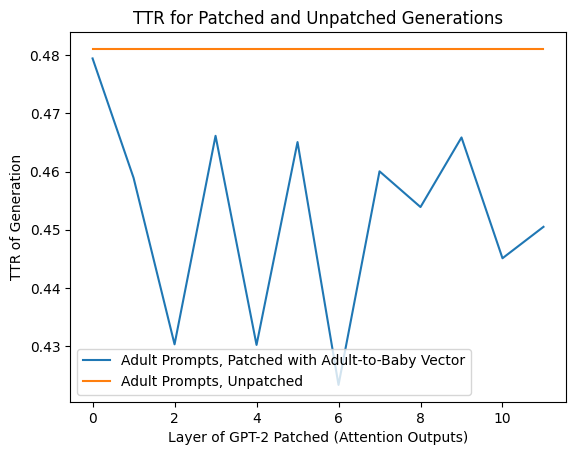

In [62]:
plt.plot(patched_richness_adult_to_baby_attn.mean(dim=1)[:,0], label="Adult Prompts, Patched with Adult-to-Baby Vector")
plt.plot(unpatched_richness_adult_to_baby_attn.mean(dim=1)[:,0], label = "Adult Prompts, Unpatched")
plt.title("TTR for Patched and Unpatched Generations")
plt.xlabel("Layer of GPT-2 Patched (Attention Outputs)")
plt.ylabel("TTR of Generation")
plt.legend()
plt.show()

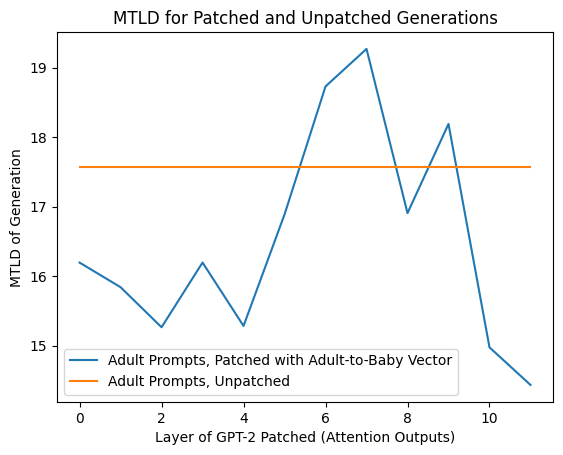

In [63]:
plt.plot(patched_richness_adult_to_baby_attn.mean(dim=1)[:,1], label="Adult Prompts, Patched with Adult-to-Baby Vector")
plt.plot(unpatched_richness_adult_to_baby_attn.mean(dim=1)[:,1], label = "Adult Prompts, Unpatched")
plt.title("MTLD for Patched and Unpatched Generations")
plt.xlabel("Layer of GPT-2 Patched (Attention Outputs)")
plt.ylabel("MTLD of Generation")
plt.legend()
plt.show()

END OF ATTENTION TESTING

In [64]:
baby_averages, baby_cache = accumulate_activations(baby_prompts, tl_model, ['blocks.0.mlp.hook_post', 'blocks.1.mlp.hook_post', 'blocks.2.mlp.hook_post', 'blocks.3.mlp.hook_post', 'blocks.4.mlp.hook_post', 'blocks.5.mlp.hook_post', 'blocks.6.mlp.hook_post', 'blocks.7.mlp.hook_post', 'blocks.8.mlp.hook_post', 'blocks.9.mlp.hook_post', 'blocks.10.mlp.hook_post', 'blocks.11.mlp.hook_post'])
adult_averages, adult_cache = accumulate_activations(adult_prompts, tl_model, ['blocks.0.mlp.hook_post', 'blocks.1.mlp.hook_post', 'blocks.2.mlp.hook_post', 'blocks.3.mlp.hook_post', 'blocks.4.mlp.hook_post', 'blocks.5.mlp.hook_post', 'blocks.6.mlp.hook_post', 'blocks.7.mlp.hook_post', 'blocks.8.mlp.hook_post', 'blocks.9.mlp.hook_post', 'blocks.10.mlp.hook_post', 'blocks.11.mlp.hook_post'])

In [65]:
adult_minus_baby = {}
for k in adult_averages.keys():
  adult_minus_baby[k] = adult_averages[k] - baby_averages[k]

baby_minus_adult = dict()
for k in adult_minus_baby.keys():
  baby_minus_adult[k] = -1 * adult_minus_baby[k]

In [66]:
prompts = [tokenizer.decode(baby_prompts[i][0])[:30] for i in np.random.choice(1000, 40)]

"""
unpatched_results_MLP = [[] for _ in range(12)]
patched_results_MLP = [[] for _ in range(12)]

for layer in range(12):
  for prompt in prompts:
    unpatched_result_MLP = generate_with_patching(prompt, patched_values_dict=adult_minus_baby, layers_to_patch=[layer], no_patch = True, num_generation=50, section="mlp.hook_post")
    patched_result_MLP = generate_with_patching(prompt, patched_values_dict=adult_minus_baby, layers_to_patch=[layer], no_patch=False, num_generation=50, section="mlp.hook_post")

    unpatched_results_MLP[layer].append(tokenizer.decode(unpatched_result_MLP)[7:])
    patched_results_MLP[layer].append(tokenizer.decode(patched_result_MLP)[7:])

with open("/content/drive/MyDrive/NLP_Final_project/unpatched_results_MLP.pkl", "wb") as file:
    pickle.dump(unpatched_results_MLP, file)

with open("/content/drive/MyDrive/NLP_Final_project/patched_results_MLP.pkl", "wb") as file:
    pickle.dump(patched_results_MLP, file)
"""

'\nunpatched_results_MLP = [[] for _ in range(12)]\npatched_results_MLP = [[] for _ in range(12)]\n\nfor layer in range(12):\n  for prompt in prompts:\n    unpatched_result_MLP = generate_with_patching(prompt, patched_values_dict=adult_minus_baby, layers_to_patch=[layer], no_patch = True, num_generation=50, section="mlp.hook_post")\n    patched_result_MLP = generate_with_patching(prompt, patched_values_dict=adult_minus_baby, layers_to_patch=[layer], no_patch=False, num_generation=50, section="mlp.hook_post")\n\n    unpatched_results_MLP[layer].append(tokenizer.decode(unpatched_result_MLP)[7:])\n    patched_results_MLP[layer].append(tokenizer.decode(patched_result_MLP)[7:])\n\nwith open("/content/drive/MyDrive/NLP_Final_project/unpatched_results_MLP.pkl", "wb") as file:\n    pickle.dump(unpatched_results_MLP, file)\n\nwith open("/content/drive/MyDrive/NLP_Final_project/patched_results_MLP.pkl", "wb") as file:\n    pickle.dump(patched_results_MLP, file)\n'

In [67]:
with open('/content/drive/MyDrive/NLP_Final_project/unpatched_results_MLP.pkl', 'rb') as f:
    unpatched_results_MLP = pickle.load(f)

with open('/content/drive/MyDrive/NLP_Final_project/patched_results_MLP.pkl', 'rb') as f:
    patched_results_MLP = pickle.load(f)

In [85]:
unpatched_results_MLP[0][0]

"Supposing I'm a parent. I'm a parent of two children, and I've been in the business of selling my own products for over twenty years. I've been in the business of selling my own products for over twenty years, and I've been in the business of selling"

In [86]:
patched_results_MLP[0][0]

"Supposing I'm a parent. I'm a parent of two children, one of whom is a teacher, and the other is a teacher of two children. I'm a parent of two children, one of whom is a teacher, and the other is a teacher of two children."

In [68]:
unpatched_richness_MLP = [[[] for _ in range(len(prompts))] for _ in range(12)] # For each of 12 layers, gives TTR, MATTR, MTLD
patched_richness_MLP  =  [[[] for _ in range(len(prompts))] for _ in range(12)] # For each of 12 layers, gives TTR, MATTR, MTLD

for layer in range(len(patched_results_MLP)):
  for prompt in range(len(patched_results_MLP[0])):
    lex_unpatched = LexicalRichness(unpatched_results_MLP[layer][prompt])
    lex_patched  =  LexicalRichness(patched_results_MLP[layer][prompt])

    unpatched_richness_MLP[layer][prompt].append(lex_unpatched.ttr)
    #unpatched_richness_MLP[layer][prompt].append(lex_unpatched.mattr(window_size=5))
    unpatched_richness_MLP[layer][prompt].append(lex_unpatched.mtld())

    patched_richness_MLP[layer][prompt].append(lex_patched.ttr)
    #patched_richness_MLP[layer][prompt].append(lex_patched.mattr(window_size=5))
    patched_richness_MLP[layer][prompt].append(lex_patched.mtld())

unpatched_richness_MLP = torch.tensor(unpatched_richness_MLP)
patched_richness_MLP = torch.tensor(patched_richness_MLP)

In [69]:
# TTR and MTLD by patched layer (patches inactive (baseline)) and all prompts (10)
unpatched_richness_MLP.mean(dim=1)

tensor([[ 0.3288, 13.2616],
        [ 0.3288, 13.2616],
        [ 0.3288, 13.2616],
        [ 0.3288, 13.2616],
        [ 0.3288, 13.2616],
        [ 0.3288, 13.2616],
        [ 0.3288, 13.2616],
        [ 0.3288, 13.2616],
        [ 0.3288, 13.2616],
        [ 0.3288, 13.2616],
        [ 0.3288, 13.2616],
        [ 0.3288, 13.2616]])

In [70]:
# TTR and MTLD by patched layer (patches active) and all prompts (10)
patched_richness_MLP.mean(dim=1)

tensor([[ 0.3252, 13.1580],
        [ 0.2985, 11.9611],
        [ 0.3195, 12.1673],
        [ 0.3201, 11.7551],
        [ 0.3286, 12.8736],
        [ 0.3216, 12.0752],
        [ 0.3229, 13.4047],
        [ 0.3257, 12.5235],
        [ 0.3228, 13.0052],
        [ 0.3317, 12.8009],
        [ 0.3089, 12.1896],
        [ 0.3276, 11.7283]])

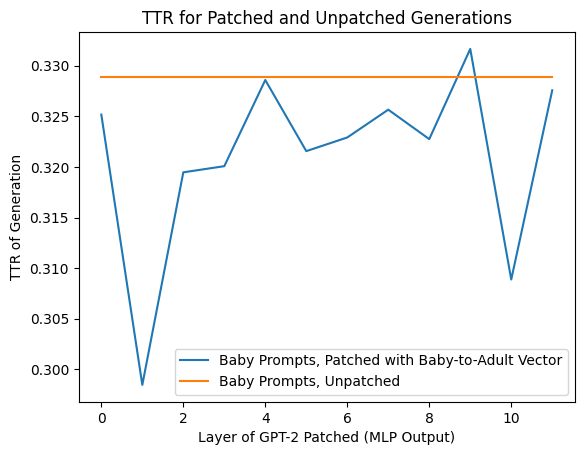

In [71]:
plt.plot(patched_richness_MLP.mean(dim=1)[:,0], label="Baby Prompts, Patched with Baby-to-Adult Vector")
plt.plot(unpatched_richness_MLP.mean(dim=1)[:,0], label = "Baby Prompts, Unpatched")
plt.title("TTR for Patched and Unpatched Generations")
plt.xlabel("Layer of GPT-2 Patched (MLP Output)")
plt.ylabel("TTR of Generation")
plt.legend()
plt.show()

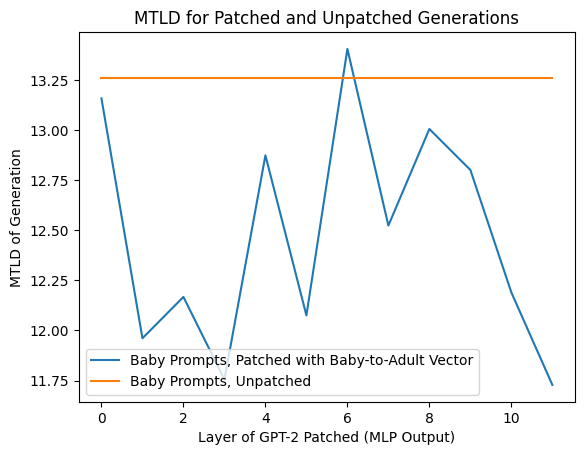

In [72]:
plt.plot(patched_richness_MLP.mean(dim=1)[:,1], label="Baby Prompts, Patched with Baby-to-Adult Vector")
plt.plot(unpatched_richness_MLP.mean(dim=1)[:,1], label = "Baby Prompts, Unpatched")
plt.title("MTLD for Patched and Unpatched Generations")
plt.xlabel("Layer of GPT-2 Patched (MLP Output)")
plt.ylabel("MTLD of Generation")
plt.legend()
plt.show()

In [73]:
prompts_adult_to_baby = [tokenizer.decode(adult_prompts[i][0])[:30] for i in np.random.choice(1000, 40)]

"""
unpatched_results_adult_to_baby_MLP = [[] for _ in range(12)]
patched_results_adult_to_baby_MLP = [[] for _ in range(12)]

for layer in range(12):
  for prompt in prompts_adult_to_baby:
    unpatched_result = generate_with_patching(prompt, patched_values_dict=baby_minus_adult, layers_to_patch=[layer], no_patch = True, num_generation=50, section="mlp.hook_post")
    patched_result = patched_text = generate_with_patching(prompt, patched_values_dict=baby_minus_adult, layers_to_patch=[layer], no_patch=False, num_generation=50, section="mlp.hook_post")

    unpatched_results_adult_to_baby_MLP[layer].append(tokenizer.decode(unpatched_result)[7:])
    patched_results_adult_to_baby_MLP[layer].append(tokenizer.decode(patched_result)[7:])

with open("/content/drive/MyDrive/NLP_Final_project/unpatched_results_adult_to_baby_MLP.pkl", "wb") as file:
    pickle.dump(unpatched_results_adult_to_baby_MLP, file)

with open("/content/drive/MyDrive/NLP_Final_project/patched_results_adult_to_baby_MLP.pkl", "wb") as file:
    pickle.dump(patched_results_adult_to_baby_MLP, file)
"""

'\nunpatched_results_adult_to_baby_MLP = [[] for _ in range(12)]\npatched_results_adult_to_baby_MLP = [[] for _ in range(12)]\n\nfor layer in range(12):\n  for prompt in prompts_adult_to_baby:\n    unpatched_result = generate_with_patching(prompt, patched_values_dict=baby_minus_adult, layers_to_patch=[layer], no_patch = True, num_generation=50, section="mlp.hook_post")\n    patched_result = patched_text = generate_with_patching(prompt, patched_values_dict=baby_minus_adult, layers_to_patch=[layer], no_patch=False, num_generation=50, section="mlp.hook_post")\n\n    unpatched_results_adult_to_baby_MLP[layer].append(tokenizer.decode(unpatched_result)[7:])\n    patched_results_adult_to_baby_MLP[layer].append(tokenizer.decode(patched_result)[7:])\n\nwith open("/content/drive/MyDrive/NLP_Final_project/unpatched_results_adult_to_baby_MLP.pkl", "wb") as file:\n    pickle.dump(unpatched_results_adult_to_baby_MLP, file)\n\nwith open("/content/drive/MyDrive/NLP_Final_project/patched_results_adult_

In [74]:
with open('/content/drive/MyDrive/NLP_Final_project/unpatched_results_adult_to_baby_MLP.pkl', 'rb') as f:
    unpatched_results_adult_to_baby_MLP = pickle.load(f)

with open('/content/drive/MyDrive/NLP_Final_project/patched_results_adult_to_baby_MLP.pkl', 'rb') as f:
    patched_results_adult_to_baby_MLP = pickle.load(f)

In [75]:
unpatched_richness_adult_to_baby_MLP = [[[] for _ in range(len(prompts))] for _ in range(12)] # For each of 12 layers, gives TTR, MATTR, MTLD
patched_richness_adult_to_baby_MLP  =  [[[] for _ in range(len(prompts))] for _ in range(12)] # For each of 12 layers, gives TTR, MATTR, MTLD

for layer in range(len(patched_results_adult_to_baby_MLP)):
  for prompt in range(len(patched_results_adult_to_baby_MLP[0])):
    lex_unpatched = LexicalRichness(unpatched_results_adult_to_baby_MLP[layer][prompt])
    lex_patched  =  LexicalRichness(patched_results_adult_to_baby_MLP[layer][prompt])

    unpatched_richness_adult_to_baby_MLP[layer][prompt].append(lex_unpatched.ttr)
    #unpatched_richness[layer][prompt].append(lex_unpatched.mattr(window_size=5))
    unpatched_richness_adult_to_baby_MLP[layer][prompt].append(lex_unpatched.mtld())

    patched_richness_adult_to_baby_MLP[layer][prompt].append(lex_patched.ttr)
    #patched_richness[layer][prompt].append(lex_patched.mattr(window_size=5))
    patched_richness_adult_to_baby_MLP[layer][prompt].append(lex_patched.mtld())

unpatched_richness_adult_to_baby_MLP = torch.tensor(unpatched_richness_adult_to_baby_MLP)
patched_richness_adult_to_baby_MLP = torch.tensor(patched_richness_adult_to_baby_MLP)

In [76]:
# TTR and MTLD by patched layer (patches inactive (baseline)) and all prompts (10)
unpatched_richness_adult_to_baby_MLP.mean(dim=1)

tensor([[ 0.4692, 17.3938],
        [ 0.4692, 17.3938],
        [ 0.4692, 17.3938],
        [ 0.4692, 17.3938],
        [ 0.4692, 17.3938],
        [ 0.4692, 17.3938],
        [ 0.4692, 17.3938],
        [ 0.4692, 17.3938],
        [ 0.4692, 17.3938],
        [ 0.4692, 17.3938],
        [ 0.4692, 17.3938],
        [ 0.4692, 17.3938]])

In [77]:
# TTR and MTLD by patched layer (patches active) and all prompts (10)
patched_richness_adult_to_baby_MLP.mean(dim=1)

tensor([[ 0.4777, 16.8227],
        [ 0.5148, 18.1991],
        [ 0.4766, 17.5105],
        [ 0.4820, 16.1629],
        [ 0.4810, 16.3332],
        [ 0.4540, 14.7675],
        [ 0.4949, 16.5400],
        [ 0.4960, 17.4675],
        [ 0.4766, 16.1052],
        [ 0.4842, 16.7660],
        [ 0.4962, 17.7004],
        [ 0.5095, 20.7556]])

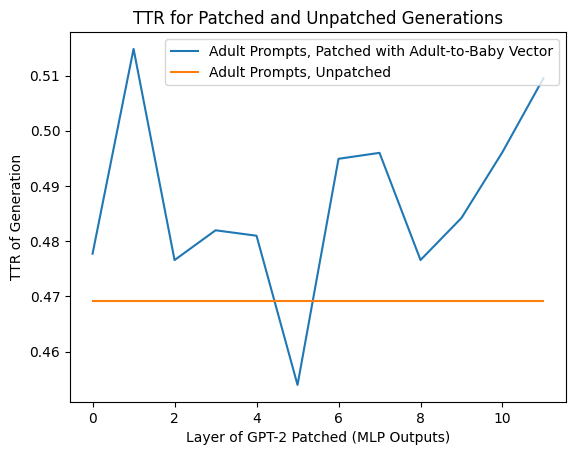

In [78]:
plt.plot(patched_richness_adult_to_baby_MLP.mean(dim=1)[:,0], label="Adult Prompts, Patched with Adult-to-Baby Vector")
plt.plot(unpatched_richness_adult_to_baby_MLP.mean(dim=1)[:,0], label = "Adult Prompts, Unpatched")
plt.title("TTR for Patched and Unpatched Generations")
plt.xlabel("Layer of GPT-2 Patched (MLP Outputs)")
plt.ylabel("TTR of Generation")
plt.legend()
plt.show()

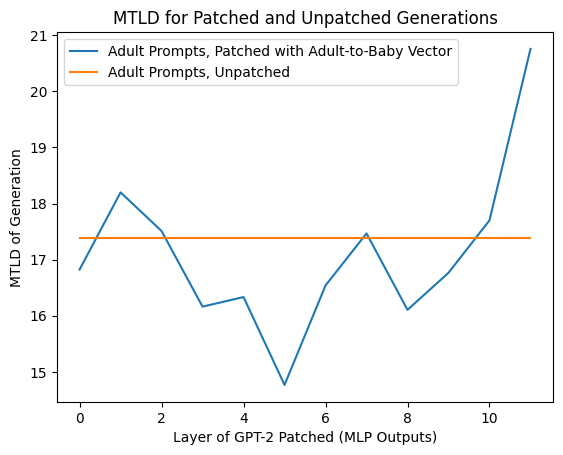

In [79]:
plt.plot(patched_richness_adult_to_baby_MLP.mean(dim=1)[:,1], label="Adult Prompts, Patched with Adult-to-Baby Vector")
plt.plot(unpatched_richness_adult_to_baby_MLP.mean(dim=1)[:,1], label = "Adult Prompts, Unpatched")
plt.title("MTLD for Patched and Unpatched Generations")
plt.xlabel("Layer of GPT-2 Patched (MLP Outputs)")
plt.ylabel("MTLD of Generation")
plt.legend()
plt.show()

END OF MLP TESTING